# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [ ]:
# Update the PATH to include the user installation directory. 
import os
# os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [ ]:
# Install requirements
!python -m pip install -r requirements.txt

## Imports

In [16]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import copy

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
def show_dataset_shapes(dataloaders):
    """
    Prints the shapes of one batch of data from the train, validation, and test datasets.

    Args:
        dataloaders (dict): A dictionary containing DataLoader objects for 'train', 'valid', and 'test'.
    """
    for phase in ['train', 'valid', 'test']:
        dataiter = iter(dataloaders[phase])
        images, labels = next(dataiter)

        print(f"{phase.capitalize()} set:")
        print(f"  Images batch shape: {images.shape}")
        print(f"  Labels batch shape: {labels.shape}")
        print(f"  Number of samples: {len(dataloaders[phase].dataset)}")
        print()


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

# Batch size
batch_size = 128

# Determine the device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Transform data for use in neural networks.

# Define data augmentation and normalization transforms for MNIST
transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=2), # Augment training data to improve robustness
    transforms.RandomHorizontalFlip(),    # Augment training data to improve robustness
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Normalization for MNIST
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Create training set and define training dataloader
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform_train)

# Split the training set into train and validation sets
train_size = int(0.8 * len(trainset))
valid_size = len(trainset) - train_size

trainset, validset = random_split(trainset, [train_size, valid_size])

# Use DataLoader to feed training data to PyTorch models
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

# Define validation dataloader
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                          shuffle=False, num_workers=4)

# Create test set and define test dataloader
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

# Update dataloaders and dataset sizes dictionaries
dataloaders = {'train': trainloader, 'valid': validloader, 'test': testloader}
dataset_sizes = {'train': len(trainset), 'valid': len(validset), 'test': len(testset)}

print()
# Explore datasets and describe their properties to set and optimize neural network parameters.
show_dataset_shapes(dataloaders)



Train set:
  Images batch shape: torch.Size([128, 1, 28, 28])
  Labels batch shape: torch.Size([128])
  Number of samples: 48000

Valid set:
  Images batch shape: torch.Size([128, 1, 28, 28])
  Labels batch shape: torch.Size([128])
  Number of samples: 12000

Test set:
  Images batch shape: torch.Size([128, 1, 28, 28])
  Labels batch shape: torch.Size([128])
  Number of samples: 10000



## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I've added to augmentation steps, one cropping with padding of 2 and RandomHorizontalFlip. This should prove the training, because of those transformations the variance of the training data is increased.

And I've configured the normalization (looked the values in the MNIST documentation).

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
import numpy as np
import matplotlib.pyplot as plt
import torchvision

classes = [str(i) for i in range(10)]

def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    
    # Mean and std for the MNIST dataset
    mean = 0.1307
    std = 0.3081

    for i in range(len(images)):
        print("Label: " + classes[labels[i].item()])
    
        image = images[i].numpy()
        
        # Denormalise
        image = image * std + mean
                
        image = np.clip(image, 0, 1)
        
        # Transpose (from PyTorch (C, H, W) to Numpy (H, W, C))
        # Since MNIST is grayscale, we do not need to transpose for color channels
        image = np.transpose(image, (1, 2, 0)) if image.shape[0] == 3 else image[0]
        
        plt.figure(figsize=(1, 1))
        plt.axis('off')
        plt.imshow(image, cmap='gray')
        plt.show()


Label: 7


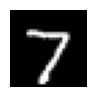

Label: 2


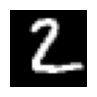

Label: 1


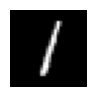

Label: 0


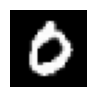

Label: 4


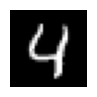

In [6]:
# Explore data
show5(testloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [9]:
import torch
import torch.nn as nn
import os

class MNISTCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(MNISTCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv1(x), 2))
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv2(x), 2))
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv3(x), 2))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MNISTCNN(num_classes=10).to(device) 
model = model.to(device)

# Select a loss function for training a classification network.
criterion = nn.CrossEntropyLoss()

# Define an optimizer to minimize loss function and update model parameters for improved accuracy.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# override the learning rate of the default optimizer and integrate a StepLR strategy (because I wanted to test that too)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print(model)

# you can load a previously saved model here
if os.path.exists("checkpoint/checkpoint.pth"):
    start_epoch, criterion = load_checkpoint(model, optimizer, 'checkpoint/checkpoint.pth')
else:
    start_epoch = 0

#start_epoch = 0
print(f"Start/Continue with epoch: {start_epoch}")

MNISTCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Start/Continue with epoch: 0


In [12]:
# Train a neural network using PyTorch to achieve a given level of accuracy.
def train_model(model, criterion, optimizer, scheduler, start_epoch=0, num_epochs=20, patience=5, min_delta=0.001):
    since = time.time()

    # lets deep copy the current model so we can return the model with the highest accuracy later on
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0
    
    train_losses = []
    valid_losses = []
    
    for epoch in range(start_epoch, num_epochs + start_epoch):
        print(f'Epoch {epoch}/{num_epochs  + start_epoch - 1}')
        print('-' * 10)

        # time measure for epoch
        epoch_since = time.time()
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # save the losses for plotting it later
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                valid_losses.append(epoch_loss)
                
            # validation Loss and Accuracy
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # check for improvement in validation phase
            if phase == 'valid':
                if epoch_acc > best_acc + min_delta:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

        # early stopping
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {patience} epochs with no improvement.')
            break

        epoch_time_elapsed = time.time() - epoch_since
        print(f'Epoch {epoch} complete in {epoch_time_elapsed // 60:.0f}m {epoch_time_elapsed % 60:.0f}s')
        print()

    # validation Loss and Accuracy
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # return the best (most accurate) model
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

**Remarks** to Loss Function:

I think CrossEntropyLoss is not so exotic, so I am going to try it with that loss function type first. Please be **aware** of the fact, that no explicit soft-max activation function needs to be defined in the output layer if CrossEntropyLoss is used. CrossEntropyLoss already implements a soft-max.

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [17]:
trained_model, train_loss, valid_loss = train_model(model, criterion, optimizer, scheduler, start_epoch=start_epoch, num_epochs=20, patience=2)

Epoch 0/19
----------
train Loss: 0.5552 Acc: 0.8150
valid Loss: 0.1747 Acc: 0.9442
Epoch 0 complete in 0m 4s

Epoch 1/19
----------
train Loss: 0.1931 Acc: 0.9407
valid Loss: 0.1137 Acc: 0.9628
Epoch 1 complete in 0m 3s

Epoch 2/19
----------
train Loss: 0.1442 Acc: 0.9547
valid Loss: 0.0799 Acc: 0.9758
Epoch 2 complete in 0m 3s

Epoch 3/19
----------
train Loss: 0.1210 Acc: 0.9619
valid Loss: 0.0738 Acc: 0.9773
Epoch 3 complete in 0m 3s

Epoch 4/19
----------
train Loss: 0.1081 Acc: 0.9671
valid Loss: 0.0671 Acc: 0.9787
Epoch 4 complete in 0m 3s

Epoch 5/19
----------
train Loss: 0.0936 Acc: 0.9708
valid Loss: 0.0624 Acc: 0.9804
Epoch 5 complete in 0m 3s

Epoch 6/19
----------
train Loss: 0.0893 Acc: 0.9717
valid Loss: 0.0549 Acc: 0.9830
Epoch 6 complete in 0m 3s

Epoch 7/19
----------
train Loss: 0.0720 Acc: 0.9768
valid Loss: 0.0480 Acc: 0.9848
Epoch 7 complete in 0m 3s

Epoch 8/19
----------
train Loss: 0.0657 Acc: 0.9790
valid Loss: 0.0432 Acc: 0.9858
Epoch 8 complete in 0m 3s

E

Plot the training loss (and validation loss/accuracy, if recorded).

In [18]:
def plot_losses(train_losses, valid_losses):
    """
    Plots the training and validation losses over epochs.

    Args:
        train_losses (list): List of training losses recorded at the end of each epoch.
        valid_losses (list): List of validation losses recorded at the end of each epoch.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

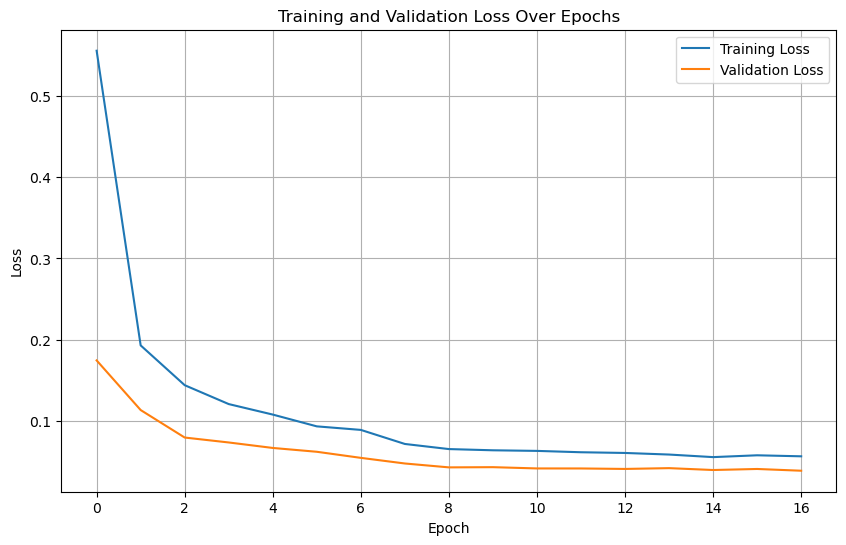

In [19]:
# Compute and plot average loss to track model performance.
plot_losses(train_loss, valid_loss)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [21]:
def evaluate_model(model, dataloader, criterion, device):
    """
    Evaluates the model on the test set.

    Args:
        model (nn.Module): The model to evaluate.
        dataloader (torch.utils.data.DataLoader): The dataloader for the test set.
        criterion (nn.CrossEntropyLoss): The loss function.
        device (torch.device): The device to evaluate on (CPU/GPU).

    Returns:
        None
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    total_loss = running_loss / len(dataloader.dataset)
    total_acc = running_corrects.double() / len(dataloader.dataset)

    print(f'Test Loss: {total_loss:.4f} Acc: {total_acc:.4f}')

In [22]:
# Use DataLoaders to test the accuracy of a model.
print("\nEvaluating the model on the test set...")
evaluate_model(model, dataloaders['test'], criterion, device)


Evaluating the model on the test set...
Test Loss: 0.0342 Acc: 0.9893


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

Sadly, there is nothing more to improve. I think nearly 99% is a good rate.

## Saving your model
Using `torch.save`, save your model for future loading.

In [23]:
# Save trained model parameters for later use.
def save_checkpoint(model, optimizer, save_dir, epoch, criterion):
    """
    Saves the current state of the model, optimizer, and other relevant information to a checkpoint file.

    Args:
        model (nn.Module): The model to save.
        optimizer (optim.Adam): The optimizer to save.
        save_dir (str): The directory to save the checkpoint file in.
        epoch (int): The current epoch.        
        criterion (nn.CrossEntropyLoss): The loss function to save.
    """
    checkpoint = {
        'epoch': epoch,        
        'state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),        
        'criterion': criterion.state_dict(),
        #'learning_rate': learning_rate
    }
    
    torch.save(checkpoint, os.path.join(save_dir, 'checkpoint.pth'))

In [24]:
save_checkpoint(model, optimizer, "./checkpoint", 20, criterion)